In [11]:
import matplotlib.pyplot as plt
import torch.sparse as sp
from scipy.sparse import lil_matrix
import torch
from paramets import *
import numpy as np
from tqdm import tqdm

## Helper Functions

In [18]:
alpha = 0.1
damping = lambda T: torch.tensor(np.exp(-alpha*T))
damping(0.3)

tensor(0.9704, dtype=torch.float64)

In [19]:
val = np.linspace(0.01, 15, num=10)
for i in val:
    print(1/damping(i))

tensor(1.0010, dtype=torch.float64)
tensor(1.1824, dtype=torch.float64)
tensor(1.3967, dtype=torch.float64)
tensor(1.6498, dtype=torch.float64)
tensor(1.9488, dtype=torch.float64)
tensor(2.3020, dtype=torch.float64)
tensor(2.7192, dtype=torch.float64)
tensor(3.2120, dtype=torch.float64)
tensor(3.7941, dtype=torch.float64)
tensor(4.4817, dtype=torch.float64)


## Rewrite the original code using torch

In [20]:
# Ng, Tf = 64, 10001

def laplacian(n):
    # Total number of grid points
    total_points = n * n
    matrix_laplacian = lil_matrix((total_points, total_points))
    
    # Fill the matrix based on finite difference method for Laplacian
    for i in range(n):
        for j in range(n):
            row = i * n + j  # Current grid point
            # Diagonal element
            matrix_laplacian[row, row] = 4
            # Check and update neighbors (left, right, up, down)
            if i > 0:
                matrix_laplacian[row, (i - 1) * n + j] = -1  # Up
            if i < n - 1:
                matrix_laplacian[row, (i + 1) * n + j] = -1  # Down
            if j > 0:
                matrix_laplacian[row, i * n + (j - 1)] = -1  # Left
            if j < n - 1:
                matrix_laplacian[row, i * n + (j + 1)] = -1  # Right
    
    # Convert to CSR format for efficient arithmetic operations
    
    matrix_laplacian = matrix_laplacian.tocsr()
    matrix_laplacian = -matrix_laplacian

    # Extract coordinates and values
    row_indices = []
    col_indices = []
    values = []

    for row in range(matrix_laplacian.shape[0]):
        start = matrix_laplacian.indptr[row]
        end = matrix_laplacian.indptr[row + 1]
        row_indices.extend([row] * (end - start))
        col_indices.extend(matrix_laplacian.indices[start:end])
        values.extend(matrix_laplacian.data[start:end])
    
    # convert to coo_matrix
    coo_matrix = torch.sparse_coo_tensor(
                torch.tensor([row_indices, col_indices], dtype=torch.int64),
                torch.tensor(values, dtype=torch.float32),
                torch.Size((n*n,n*n))
                )
    return coo_matrix

master_list = []
def integrate(L, u, T):
    '''  simulates the equation and plots it at different instants '''
    T = torch.tensor([T], device='cpu')
    for i in range(Tf.item()):
        noise = torch.normal(mean=0.0, std=1.0, size=(Ng * Ng, 1), device='cpu')
        u = u - (dt/damping(T)) * (a * u + b * u * u * u - c - k * torch.mm(L, u)) + (torch.sqrt(2 * T * dt)/damping(T)) * noise  # Euler's method
        if (i==10000):
            master_list.append(u)

## Calculate the mean of configurations

In [21]:
def avg_realizations(master_list, Ng):
    """ Evaluate the average over the configurations (realizations)"""
    mean_config = []
    size = len(master_list)
    N = Ng*Ng
    temp = 0
    for point in tqdm(range(N), desc="Processing", ncols=100, ascii=True):
        for config in range(size):
            temp += master_list[config][point]
        mean_config.append(temp/size)
        temp = 0
    mean_config = torch.tensor(mean_config)
    mean_config = mean_config.view((Ng, Ng))
    plt.figure(figsize=(4, 3))
    plt.imshow(mean_config)
    plt.show()
    return mean_config

# mean_config = avg_realizations(master_list, Ng)
# plt.imshow(mean_config)
# plt.show()

In [22]:
def avg_final(mean_config, Ng):
    sum = 0 
    for x in range(Ng):
        for y in range(Ng):
            sum = sum + mean_config[x][y]
    return sum / (Ng*Ng)

# media_final(mean_config, Ng)

## RUN PIPELINE

In [23]:
# generate the grid and initialise the field

## define o dispositivo cuda a ser utilizado

device = torch.device('cpu')

x = torch.linspace(-1, 1, Ng)
y = torch.linspace(-1, 1, Ng)
X, Y = torch.meshgrid(x, y)

## simula 100 configurações finais com os parametros iniciais
L = laplacian(Ng)
L = L.to(device)         # construct the laplacian
N_real = 50

list_vev = []
# list_temperature = [0.01, 5]

In [ ]:
# for T in list_temperature:
#   print(f"---------------- Temperature: {T} --------------------- ")
#   for realization in tqdm(range(N_real), desc="Processing", ncols=100, ascii=True):
#     u = torch.randn(Ng * Ng, 1, device=device)  # Initial data
#     integrate(L, u, T)    # simulate
#     # if realization % 10 ==0:
#       # print(f'Realization: {realization}')

#   mean_config = avg_realizations(master_list, Ng)
#   VEV = avg_final(mean_config, Ng)
#   list_vev.append(VEV)

---------------- Temperature: 0.01 --------------------- 


Processing:   0%|                                                            | 0/50 [00:00<?, ?it/s]C:\Users\jdss0\AppData\Local\Temp\ipykernel_16888\224871084.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  damping = lambda T: torch.tensor(np.exp(-alpha*T))
Processing: 100%|#############################################| 4096/4096 [00:03<00:00, 1283.61it/s]


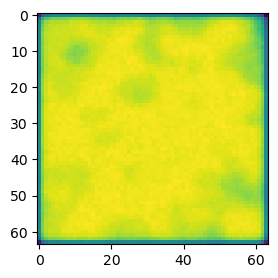

---------------- Temperature: 1.6755555555555557 --------------------- 


Processing: 100%|#############################################| 4096/4096 [00:02<00:00, 1384.25it/s]


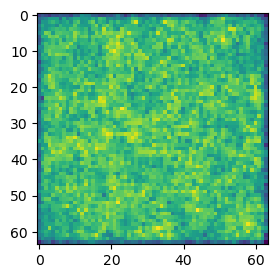

---------------- Temperature: 3.341111111111111 --------------------- 


Processing: 100%|##############################################| 4096/4096 [00:04<00:00, 885.05it/s]


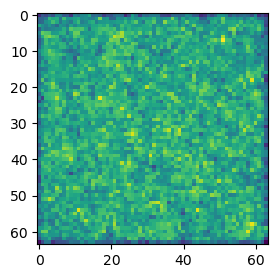

---------------- Temperature: 5.006666666666667 --------------------- 


Processing: 100%|##############################################| 4096/4096 [00:05<00:00, 702.69it/s]


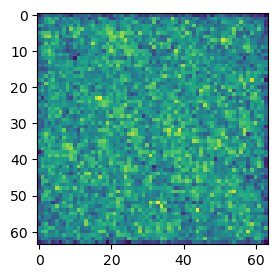

---------------- Temperature: 6.6722222222222225 --------------------- 


Processing: 100%|##############################################| 4096/4096 [00:07<00:00, 532.64it/s]


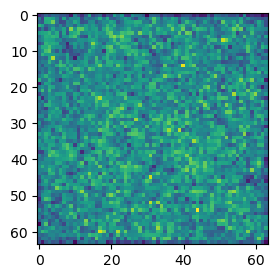

---------------- Temperature: 8.337777777777779 --------------------- 


Processing: 100%|##############################################| 4096/4096 [00:07<00:00, 529.20it/s]


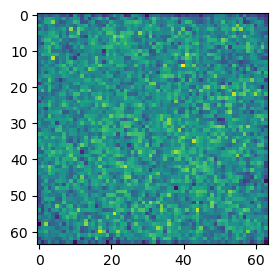

---------------- Temperature: 10.003333333333334 --------------------- 


Processing: 100%|##############################################| 4096/4096 [00:09<00:00, 444.11it/s]


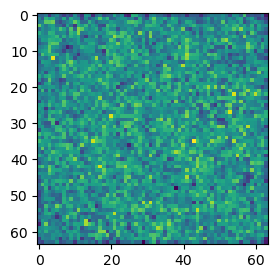

---------------- Temperature: 11.668888888888889 --------------------- 


Processing: 100%|##############################################| 4096/4096 [00:10<00:00, 396.40it/s]


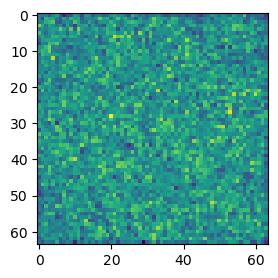

---------------- Temperature: 13.334444444444445 --------------------- 


Processing: 100%|##############################################| 4096/4096 [00:11<00:00, 349.16it/s]


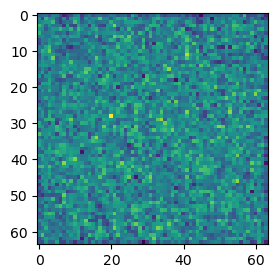

---------------- Temperature: 15.0 --------------------- 


Processing: 100%|##############################################| 4096/4096 [00:13<00:00, 312.34it/s]


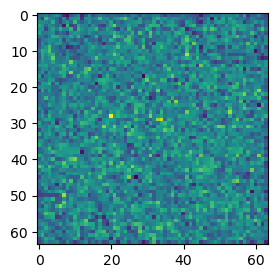

In [24]:
for T in np.linspace(0.01, 15, num=10):
  T = float(T)
  print(f"---------------- Temperature: {T} --------------------- ")
  for realization in tqdm(range(N_real), desc="Processing", ncols=100, ascii=True):
    u = torch.randn(Ng * Ng, 1, device=device)  # Initial data
    integrate(L, u, T)    # simulate
    # if realization % 10 ==0:
      # print(f'Realization: {realization}')

  mean_config = avg_realizations(master_list, Ng)
  VEV = avg_final(mean_config, Ng)
  list_vev.append(VEV)

In [25]:
list_vev

[tensor(0.9936),
 tensor(0.5871),
 tensor(0.4136),
 tensor(0.3193),
 tensor(0.2633),
 tensor(0.2237),
 tensor(0.1936),
 tensor(0.1720),
 tensor(0.1547),
 tensor(0.1401)]

In [26]:
list_T = np.linspace(0.01, 15, num=10)[:10]
list_T = list(list_T)
list_T

[0.01,
 1.6755555555555557,
 3.341111111111111,
 5.006666666666667,
 6.6722222222222225,
 8.337777777777779,
 10.003333333333334,
 11.668888888888889,
 13.334444444444445,
 15.0]

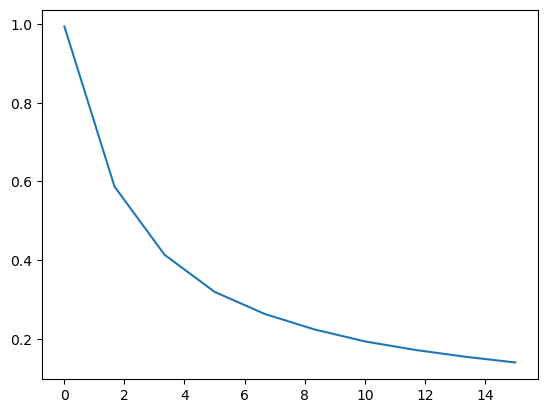

In [28]:
plt.plot(list_T, list_vev)
plt.show()

In [ ]:
list_temperature = np.linspace(0.01, 15, num=30)